In [1]:
%matplotlib inline
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import copy

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)

In [3]:
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/s')
scaler = plotter.scaler

In [4]:
amp = pickle.load(open('amp.pkl','rb'))

In [5]:
def choose_orb(height, step):
    orbs = pickle.load(open('LogClean/{}.bin'.format(height),'rb'))
    orb = orbs[step]['orbit']
    plt.plot(amp['x0'],amp['z0'],'ob')
    plt.plot(orb.iloc[0]['x'],orb.iloc[0]['z'],'or')
    plt.axis('equal')
    plt.plot(model.L1,0,'rx')
    return orb

In [251]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def hyper_part(self, state):
        (x, y) = state[:2]
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

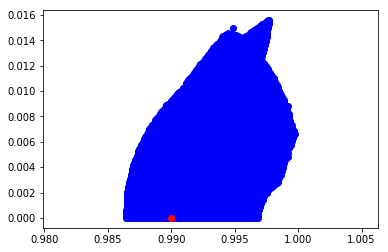

In [236]:
orb = choose_orb(0, 54)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f784c4630>,
      dtype=object)

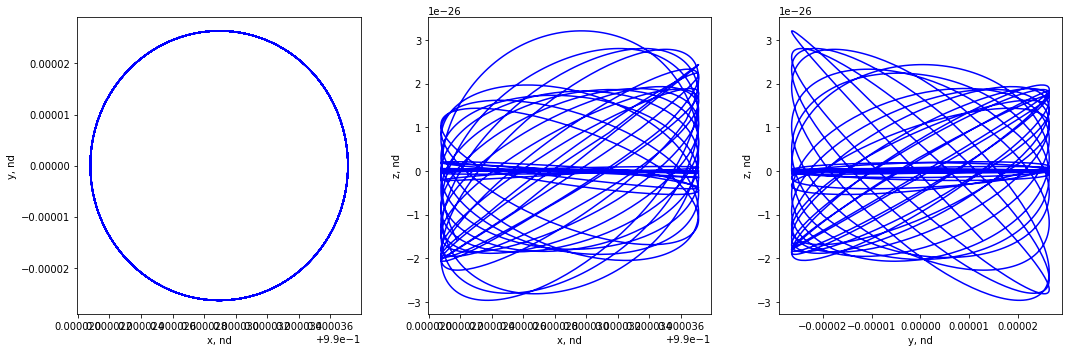

In [237]:
plotter.plot_proj(orb)

In [249]:
scaler(np.linalg.norm(orb.iloc[0][1:4]-np.array([model.L1,0,0])), 'nd-km')

1220.3794047112915

In [254]:
hyp = Hyperbolic()

In [255]:
st = orb.iloc[0].values[1:].copy()
st[0] -= model.L1

## Гиперболическая часть:

In [256]:
hyp.hyper_part(st)

-4.9958990269644996e-09

Text(0.5, 0, 't, nd')

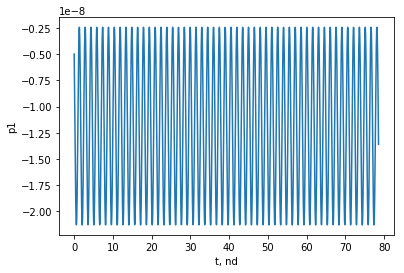

In [258]:
plt.plot(orb['t'], hps)
plt.ylabel('p1')
plt.xlabel('t, nd')

In [259]:
vy_def = orb.iloc[0].values[5]
dv = 0.01
vys = np.linspace(vy_def-dv, vy_def+dv, 50)
dist_states = []
for vy in vys:
    new_state = orb.iloc[0].values[1:].copy()-np.array([model.L1,0,0,0,0,0])
    new_state[4] = vy
    dist_states.append(new_state)

In [260]:
hps1 = [hyp.hyper_part(state) for state in dist_states]

In [264]:
vy_approx = hyp.calc_vy(orb.iloc[0].values[1:]-np.array([model.L1,0,0,0,0,0]))

## Ошибка по скорости относительно метода плоскостей:

In [267]:
np.abs(vy_approx-vy_def)

3.9729893835059853e-08

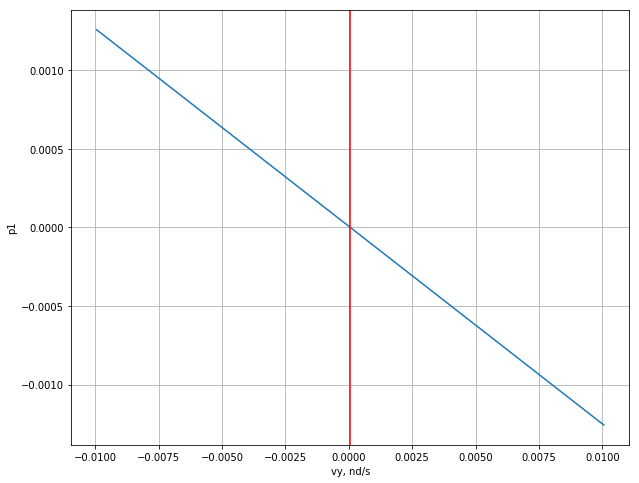

In [246]:
plt.figure(figsize=(10,8))
plt.plot(vys, hps1)
plt.ylabel('p1')
plt.xlabel('vy, nd/s')
plt.grid(True)
plt.axvline(vy_def, color='r')